### Source
Data from “The Instacart Online Grocery Shopping Dataset 2017”, accessed from https://www.instacart.com/datasets/grocery-shopping-2017 by Practicum, who provided me with a modified version.

# Introduction 

I am completing a project on Exploratory Data Analysis using a dataset released in 2017 by Instacart for a Kaggle competition. Practicum edited the dataset to reduce the size while maintaining the original distributions and patterns. There are five datasets provided, containing information about Instacart orders and products in America over the span of the year 2017. 

I will first familiarize myself with the data and find/fix duplicate data and missing values where needed, while explaining my rationale behind my decisions, how I made my adjustments, and the potential causes behind any discrepancies I find.

Afterwards I will begin to analyze this processed data. I will look for patterns in when people order groceries, which I will liekly achieve using bar charts, since the index values are discrete. I want to investigate how many orders people tend to place, and what those orders tend to look like (i.e. do people tend to repeatedly place similar orders? This information could be used to predict future orders). Beyond that, I am curious which products themselves tend to be ordered the most frequently, and I can look at a few variations on how "popular" is defined - for instance, which products are ordered the most often, which products are reordered the most often, etc.

Throughout the project, I will try to clearly describe what I am doing, and I will try to use a variety of relevant techniques to gain experience working with these techniques. However, ultimately I will use similar techniques several times if it is the most appropriate choice, as I want to also gain experience in being efficient and choosing the best tools for each problem.

# Load libraries, create dataframes, explore data

In [1]:
# Load libraries and notebook settings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.set_option('display.max_rows', 500)

Data files:
- /datasets/instacart_orders.csv
- /datasets/products.csv
- /datasets/aisles.csv
- /datasets/departments.csv
- /datasets/order_products.csv

In [2]:
# Load data into dataframes
orders = pd.read_csv('instacart_orders.csv')
products = pd.read_csv('instacart_products.csv')
aisles = pd.read_csv('instacart_aisles.csv')
departments = pd.read_csv('instacart_departments.csv')
order_products = pd.read_csv('instacart_order_products.csv')

- I looked at the heads first to get a feel for the data and to check the delimiters in the files.
- Then I looked at the info for each dataset to get an idea of the datatypes. All of the number-based columns, whether quantitative or categorical, were read in as integers, so I know that there won't be any problems there. However, there are NaN values in some columns, indicated by non-null vaue counts being lower than the number of columns, and float64 dtypes where there should be int64 dtypes.
- Because some of the files are quite large, I turned some of the int64 dtypes into smaller int dtypes to save memory. To accomplish this without compromising data quality, I used .describe() to look at the maximum values for each column and crosschecked these with dtype documentation, ensuring that the new dtypes could hold all of the information.
- I am going to leave the .describe() and .info() data displayed below for easy reference throughout my project.

# orders

In [3]:
# Let's look at some general info for the orders df, and change int types to save memory
display(orders.head())
display(orders.describe())
orders[['order_id', 'user_id']] = orders[['order_id', 'user_id']].astype('int32')
orders[['order_number', 'order_dow', 'order_hour_of_day']] = \
orders[['order_number', 'order_dow', 'order_hour_of_day']].astype('int8')
orders.info()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1515936,183418,11,6,13,30.0
1,1690866,163593,5,5,12,9.0
2,1454967,39980,4,5,19,2.0
3,1768857,82516,56,0,20,10.0
4,3007858,196724,2,4,12,17.0


,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,4.789670e+05,478967.000000,478967.000000,478967.000000,478967.000000,450148.000000
mean,1.709947e+06,102966.537475,17.157808,2.775058,13.446676,11.101751
std,9.869480e+05,59525.328991,17.704688,2.045869,4.224986,9.189975
min,4.000000e+00,2.000000,1.000000,0.000000,0.000000,0.000000
25%,8.564685e+05,51414.000000,5.000000,1.000000,10.000000,4.000000
50%,1.709522e+06,102633.000000,11.000000,3.000000,13.000000,7.000000
75%,2.562990e+06,154419.000000,23.000000,5.000000,16.000000,15.000000
max,3.421079e+06,206209.000000,100.000000,6.000000,23.000000,30.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478967 entries, 0 to 478966
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                478967 non-null  int32  
 1   user_id                 478967 non-null  int32  
 2   order_number            478967 non-null  int8   
 3   order_dow               478967 non-null  int8   
 4   order_hour_of_day       478967 non-null  int8   
 5   days_since_prior_order  450148 non-null  float64
dtypes: float64(1), int32(2), int8(3)
memory usage: 8.7 MB


- I am trying to figure out which day of the week is "day 0" in orders.order_dow. I tried to find an answer by looking at the actual data documentation from the source, but I did not find any documentation from them describing the columns.
- Traditionally, Monday is designated as Day 0. Therefore, my decision will be between:
    1. Assuming that Monday is indeed Day 0, and perhaps finding interesting patterns in the data based on that assumption, or
    2. Looking for patterns in the data, and assigning Day names to each day number based on my data findings
- I would like to pursue option 2 for this project. To figure this out I am going to try to look at distributions for order traffic over time, and maybe I can identify which days indicate the weekend. I will make a pivot table and then plot that as a line graph with a different line for each day of the week.
- If I later figure out definitively which day is which, it will be straightforward for me to adjust my data analysis in this project.

In [4]:
# Make pivot table that counts the number of orders placed per day per hour
orders_pivot = orders.pivot_table(columns='order_dow', index='order_hour_of_day', aggfunc='count', values='order_id')
orders_pivot.head()

order_dow,0,1,2,3,4,5,6
order_hour_of_day,,,,,,,
0,533,565,462,373,324,459,464
1,337,269,240,215,229,219,254
2,188,145,136,121,114,123,177
3,128,104,104,101,109,99,125
4,108,104,109,108,100,118,118


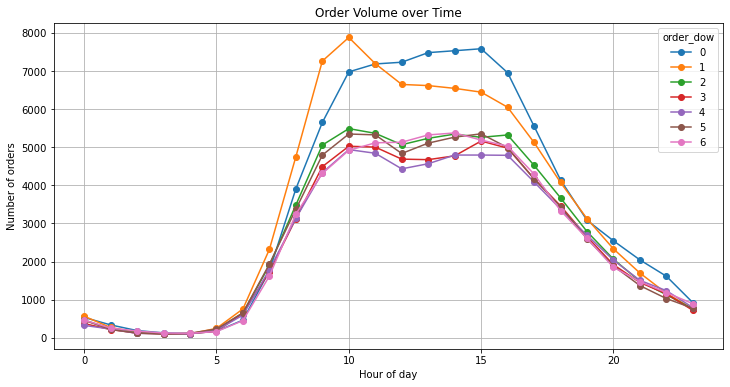

In [5]:
# Plot pivot table to look at a line graph of order volume per day per hour
orders_pivot.plot(figsize=[12,6], grid=True, style='o-',
          title='Order Volume over Time',
          ylabel='Number of orders',
          xlabel='Hour of day')
plt.show()

- Days 0 and 1 are vastly different from the other days. The other five days are all very similar. Days 0 and 1 are likely Saturday and Sunday, even though it seems extremely odd, notationally, for the days to begin on Saturday. It does make sense to me that order volume would be highest on weekends, specifically peaking on Saturday afternoons and Sunday mornings, because the typical American works M-F ~8am-5pm and has off work on weekends; they have time to browse, place their orders, then pick them up. 
- If Day 0 were Monday, and Day 1 were Tuesday, this would mean that most Americans place their orders during work on Mondays and Tuesdays. In this case, why are Monday and Tuesday so distinct from Wednesdays or Thursdays? This may be a bias, as I currently shop and have generally always shopped for groceries on weekends.
- I am deciding that Day 0 is Saturday. In the real world, it is likely that I would be able to ask someone which day is which; it seems like it would be a failure of the data processing/engineering team to leave this information so ambiguous. If I received confirmation that Day 0 were Saturday, I would likely seek out a good reason why they assigned Saturday to Day 0, and request that they modify the data so that Day 0 is Monday. And conversely, if I found that Day 0 were Monday, I could modify my orders dataframe such that I wouldn't have to revise any of my calculations (i.e. modify the orders.order_dow column so that day 0 actually is Saturday).

# products

In [6]:
# Looking at general info for products df, changing int types, and cleaning up product names by making them lowercase
display(products.describe())
products.product_id = products.product_id.astype('int32')
products.aisle_id = products.aisle_id.astype('int16')
products.department_id = products.department_id.astype('int8')
products.product_name = products.product_name.str.lower()
display(products.head())
products.info()

,product_id,aisle_id,department_id
count,49694.000000,49694.000000,49694.000000
mean,24847.500000,67.773192,11.728478
std,14345.566475,38.317265,5.850314
min,1.000000,1.000000,1.000000
25%,12424.250000,35.000000,7.000000
50%,24847.500000,69.000000,13.000000
75%,37270.750000,100.000000,17.000000
max,49694.000000,134.000000,21.000000


,product_id,product_name,aisle_id,department_id
0,1,chocolate sandwich cookies,61,19
1,2,all-seasons salt,104,13
2,3,robust golden unsweetened oolong tea,94,7
3,4,smart ones classic favorites mini rigatoni wit...,38,1
4,5,green chile anytime sauce,5,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49694 entries, 0 to 49693
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49694 non-null  int32 
 1   product_name   48436 non-null  object
 2   aisle_id       49694 non-null  int16 
 3   department_id  49694 non-null  int8  
dtypes: int16(1), int32(1), int8(1), object(1)
memory usage: 728.1+ KB


# aisles

In [7]:
# Looking at aisles df, changing int types, and turning strings to lowercase
display(aisles.describe())
aisles.aisle_id = aisles.aisle_id.astype('int16')
aisles.aisle = aisles.aisle.str.lower()
display(aisles.head())
aisles.info()

,aisle_id
count,134.000000
mean,67.500000
std,38.826537
min,1.000000
25%,34.250000
50%,67.500000
75%,100.750000
max,134.000000


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int16 
 1   aisle     134 non-null    object
dtypes: int16(1), object(1)
memory usage: 1.4+ KB


# departments

In [8]:
# Looking at departments df, changing int types, and turning strings to lowercase
display(departments.describe())
departments.department_id = departments.department_id.astype('int8')
departments.department = departments.department.str.lower()
display(departments.head())
departments.info()

,department_id
count,21.000000
mean,11.000000
std,6.204837
min,1.000000
25%,6.000000
50%,11.000000
75%,16.000000
max,21.000000


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int8  
 1   department     21 non-null     object
dtypes: int8(1), object(1)
memory usage: 317.0+ bytes


# order-products

In [9]:
# Looking at order_products df and changing int types
display(order_products.head())
display(order_products.describe())
order_products[['order_id', 'product_id']] = order_products[['order_id', 'product_id']].astype('int32')
order_products.reordered = order_products.reordered.astype('int8')
order_products.info(show_counts=True)

,order_id,product_id,add_to_cart_order,reordered
0,2141543,11440,17.0,0
1,567889,1560,1.0,1
2,2261212,26683,1.0,1
3,491251,8670,35.0,1
4,2571142,1940,5.0,1


,order_id,product_id,add_to_cart_order,reordered
count,4.545007e+06,4.545007e+06,4.544171e+06,4.545007e+06
mean,1.711166e+06,2.558084e+04,8.351669e+00,5.905025e-01
std,9.850955e+05,1.409552e+04,7.080368e+00,4.917411e-01
min,4.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.608170e+05,1.353500e+04,3.000000e+00,0.000000e+00
50%,1.711530e+06,2.527200e+04,6.000000e+00,1.000000e+00
75%,2.561311e+06,3.793500e+04,1.100000e+01,1.000000e+00
max,3.421079e+06,4.969400e+04,6.400000e+01,1.000000e+00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4545007 entries, 0 to 4545006
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   order_id           4545007 non-null  int32  
 1   product_id         4545007 non-null  int32  
 2   add_to_cart_order  4544171 non-null  float64
 3   reordered          4545007 non-null  int8   
dtypes: float64(1), int32(2), int8(1)
memory usage: 73.7 MB


## Find and remove duplicate values (and describe why you make your choices)

### `orders` data frame

In [10]:
# Check for explicitly duplicated orders
orders.duplicated().sum()

15

In [11]:
# Check for all orders placed Wednesday at 2:00 AM 
# Per my earlier decision, Wednesday is day 4
wed_0200_orders = orders[(orders.order_dow == 4) & (orders.order_hour_of_day == 2)]
display(len(wed_0200_orders))
display(wed_0200_orders)

114

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
2124,401544,80955,72,4,2,2.0
14847,1913472,138992,16,4,2,6.0
16116,2796392,154904,12,4,2,13.0
16471,2209130,72786,5,4,2,30.0
32120,2235095,89980,18,4,2,7.0
32426,3400949,76168,2,4,2,25.0
34081,1335087,59328,23,4,2,25.0
39368,605787,52824,37,4,2,1.0
43515,3407108,46375,1,4,2,NaN
45762,2604454,122001,3,4,2,3.0


In [12]:
# Remove explicitly duplicate orders
orders = orders.drop_duplicates().reset_index(drop=True)

In [13]:
# Double check for explicitly duplicate rows
orders.duplicated().sum()

0

In [14]:
# Double check for duplicate order IDs only
orders.duplicated(subset='order_id').sum()

0

I do not believe there are any duplicates in this table. There are no fully duplicate rows, and no duplicate order ID's. 

### `products` data frame

In [15]:
# Check for fully duplicate rows
products.duplicated().sum()

0

In [16]:
# Check for just duplicate product IDs
products.duplicated(subset='product_id').sum()

0

In [17]:
# Check for just duplicate product names (convert names to lowercase to compare better)
# I converted product names to lowercase above 
products.duplicated(subset='product_name').sum()

1361

In [18]:
# Check for duplicate product names that aren't missing
notnull_product_names = products[(products.product_name.duplicated()) & (~products.product_name.isna())]
display(len(notnull_product_names))

104

In [19]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49694 entries, 0 to 49693
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49694 non-null  int32 
 1   product_name   48436 non-null  object
 2   aisle_id       49694 non-null  int16 
 3   department_id  49694 non-null  int8  
dtypes: int16(1), int32(1), int8(1), object(1)
memory usage: 728.1+ KB


In [20]:
# I want to check a few rows to visualize these duplicates. 
display(products[products.product_name == 'biotin 1000 mcg'])
# display(products[products.product_name == 'american cheese slices'])

,product_id,product_name,aisle_id,department_id
41,42,biotin 1000 mcg,47,11
2058,2059,biotin 1000 mcg,47,11


In [21]:
# # Here I will drop those 104 duplicates by removing and storing the NaN values, dropping the duplicates, then concatenating the
# # NaN rows back into the dataframe.
# products_nan = products[products.product_name.isna()] # store NaN rows
# products = products.dropna() # remove nans
# products = products.drop_duplicates(subset='product_name') # remove duplicates
# # print(products_nan.head())
# # print(products.head())
# products = pd.concat([products, products_nan]) # add NaN rows back to df
# products = products.sort_values(by='product_id') # sort values by product_id
# products = products.reset_index(drop=True) # reset the index
# # print(products.head(45))
# products.info()

# # Checking info before and after this adjustment lets me see that there is a difference of 104 rows in the table.

- I found 104 implicitly duplicate rows where the non-null product name was duplicated but the product_id was not. 

- I had originally wanted to remove these 104 duplicate rows. I decided to remove and store the NaN rows, drop the duplicates from the products df, then stitch the NaN rows back into the products df. 

- Later in the project, I realized this data was important to the order_products dataframe. I came back and commented out these edits. I want to keep these 104 duplicate values to protect order_products information later in the project, but I kept the cell block here in case I decide to remove them in the future for any reason.

### `departments` data frame

In [22]:
# Check for fully duplicate rows
departments.duplicated().sum()

0

In [23]:
# Check for duplicate departments and department_id's individually to be safe
print(departments.duplicated(subset='department').sum())
print(departments.duplicated(subset='department_id').sum())

0
0


In [24]:
# There aren't too many departments, so let's look for implicit duplicates
display(sorted(departments.department.unique())) # sort the dept names alphabetically
# I don't see any implicitly duplicate dept names
#  Visually, however, there is a department named "missing". Let's investigate in the next step.

['alcohol',
 'babies',
 'bakery',
 'beverages',
 'breakfast',
 'bulk',
 'canned goods',
 'dairy eggs',
 'deli',
 'dry goods pasta',
 'frozen',
 'household',
 'international',
 'meat seafood',
 'missing',
 'other',
 'pantry',
 'personal care',
 'pets',
 'produce',
 'snacks']

In [25]:
departments[departments.department == 'missing']
# It appears that the missing department has a department ID of 21.

,department_id,department
20,21,missing


I have no reason to suspect duplicates in this table. Examining the department names reveals no implicit duplicates. However, I did discover that dept 21 (the department with a department_id of 21) is missing.

### `aisles` data frame

In [26]:
# Check for fully duplicate rows
aisles.duplicated().sum()

0

In [27]:
# Check for duplicate aisles and aisle_id's to be safe
print(aisles.duplicated(subset='aisle').sum())
print(aisles.duplicated(subset='aisle_id').sum())

0
0


In [28]:
# Let's check for implicitly duplicate aisle names
display(sorted(aisles.aisle.unique())) # sort the aisle names alphabetically
# I don't see any implicitly duplicate aisle names
#  Visually, there is an aisle named "missing". Let's investigate.

['air fresheners candles',
 'asian foods',
 'baby accessories',
 'baby bath body care',
 'baby food formula',
 'bakery desserts',
 'baking ingredients',
 'baking supplies decor',
 'beauty',
 'beers coolers',
 'body lotions soap',
 'bread',
 'breakfast bakery',
 'breakfast bars pastries',
 'bulk dried fruits vegetables',
 'bulk grains rice dried goods',
 'buns rolls',
 'butter',
 'candy chocolate',
 'canned fruit applesauce',
 'canned jarred vegetables',
 'canned meals beans',
 'canned meat seafood',
 'cat food care',
 'cereal',
 'chips pretzels',
 'cleaning products',
 'cocoa drink mixes',
 'coffee',
 'cold flu allergy',
 'condiments',
 'cookies cakes',
 'crackers',
 'cream',
 'deodorants',
 'diapers wipes',
 'digestion',
 'dish detergents',
 'dog food care',
 'doughs gelatins bake mixes',
 'dry pasta',
 'eggs',
 'energy granola bars',
 'energy sports drinks',
 'eye ear care',
 'facial care',
 'feminine care',
 'first aid',
 'food storage',
 'fresh dips tapenades',
 'fresh fruits',
 'f

In [29]:
aisles[aisles.aisle == 'missing']
# It appears that the missing aisle has an aisle ID of 100.

,aisle_id,aisle
99,100,missing


I found no explicit duplicates in this table, and saw no implicit duplicates while skimming the aisle names. However, I did discover that aisle 100 (the aisle with an aisle_id of 100) is missing

### `order_products` data frame

In [30]:
# Check for fully duplicate rows
order_products.duplicated().sum()

0

In [31]:
order_products.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4545007 entries, 0 to 4545006
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   order_id           4545007 non-null  int32  
 1   product_id         4545007 non-null  int32  
 2   add_to_cart_order  4544171 non-null  float64
 3   reordered          4545007 non-null  int8   
dtypes: float64(1), int32(2), int8(1)
memory usage: 73.7 MB


In [32]:
# Double check for any other tricky duplicates
# I first want to look at an example of an order, so I will filter by a single order_id.
display(order_products[order_products.order_id == 2141543].sort_values(by='add_to_cart_order'))

,order_id,product_id,add_to_cart_order,reordered
3921615,2141543,13166,1.0,1
1462858,2141543,13176,2.0,1
4168533,2141543,26914,3.0,1
2995037,2141543,27521,4.0,1
2875605,2141543,16759,5.0,1
4258133,2141543,37646,6.0,1
3617023,2141543,12456,7.0,1
2804865,2141543,6187,8.0,1
349394,2141543,30233,9.0,1
4416044,2141543,29926,10.0,1


In [33]:
# I want to check if there are instances where on 1 particular order_id, there are duplicated product_id's/add_to_cart_order's.
display(order_products[(order_products.duplicated(subset=['order_id', 'add_to_cart_order']) \
                        & (~order_products.add_to_cart_order.isna()))])
display(order_products[order_products.duplicated(subset=['order_id', 'product_id'])])

,order_id,product_id,add_to_cart_order,reordered


,order_id,product_id,add_to_cart_order,reordered


- There are zero instances where one order contains duplicate product_id's or add_to_cart_order's.

- I am deciding that the order_products dataframe is free from duplicates.

## Find and remove missing values


### `products` data frame

In [34]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49694 entries, 0 to 49693
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49694 non-null  int32 
 1   product_name   48436 non-null  object
 2   aisle_id       49694 non-null  int16 
 3   department_id  49694 non-null  int8  
dtypes: int16(1), int32(1), int8(1), object(1)
memory usage: 728.1+ KB


In [35]:
# Are all of the missing product names associated with aisle ID 100?
products_nan = products[products.product_name.isna()] # store NaN rows

display(products_nan.groupby(['aisle_id']).product_id.count()) # count product_id's for just aisle 100

aisle_id
100    1258
Name: product_id, dtype: int64

In [36]:
# Are all of the missing product names associated with department ID 21?

display(products_nan.groupby(['department_id']).product_id.count()) # count product_id's for just dept 21

department_id
21    1258
Name: product_id, dtype: int64

In [37]:
# I need to make sure that these 1258 missing product names overlap completely
display(products_nan.groupby(['aisle_id', 'department_id']).product_id.count())

aisle_id  department_id
100       21               1258
Name: product_id, dtype: int64

In [38]:
# What is this aisle and department?
# Aisle 100 and dept 21 are both labeled as 'missing'.

print(aisles[aisles.aisle_id == 100]) # print name of aisle 100
print(departments[departments.department_id == 21]) # print name of dept 21
display(products[products.product_name.isna()].head()) # print a few rows from products df where product name is NaN

    aisle_id    aisle
99       100  missing
    department_id department
20             21    missing


,product_id,product_name,aisle_id,department_id
37,38,NaN,100,21
71,72,NaN,100,21
109,110,NaN,100,21
296,297,NaN,100,21
416,417,NaN,100,21


In [39]:
# I just want to make sure that at least one product id with missing information was indeed ordered.
# Since at least one was ordered, I can't drop these missing rows without losing valuable information.
order_products[order_products.product_id == 38]

,order_id,product_id,add_to_cart_order,reordered
1062620,2085048,38,5.0,0
3632238,1528601,38,12.0,0
4288303,2360582,38,10.0,0


In [40]:
# Fill missing product names with 'Unknown'
products.product_name = products.product_name.fillna('unknown')

In [41]:
# I am verifying the success of these replacements.
display(products[products.product_name == 'unknown'].sample(10))

,product_id,product_name,aisle_id,department_id
11892,11893,unknown,100,21
28973,28974,unknown,100,21
13295,13296,unknown,100,21
7961,7962,unknown,100,21
35512,35513,unknown,100,21
47251,47252,unknown,100,21
26302,26303,unknown,100,21
15747,15748,unknown,100,21
41186,41187,unknown,100,21
11666,11667,unknown,100,21


In [42]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49694 entries, 0 to 49693
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49694 non-null  int32 
 1   product_name   49694 non-null  object
 2   aisle_id       49694 non-null  int16 
 3   department_id  49694 non-null  int8  
dtypes: int16(1), int32(1), int8(1), object(1)
memory usage: 728.1+ KB


I found missing product names, and correlated every missing product name to aisle 100 and department 21. It seems likely that whoever created these csv files deemed these products with missing names to be important to the overall dataset, and assigned them both a dedicated department and a dedicated aisle to help categorize them. I also feel that they are important to keep, because at least one of these products was ordered, which I checked using my order_products df. For these reasons, I will not remove these missing values, but instead replace them with "unknown".

### `orders` data frame

In [43]:
orders.info()
display(orders.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478952 entries, 0 to 478951
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                478952 non-null  int32  
 1   user_id                 478952 non-null  int32  
 2   order_number            478952 non-null  int8   
 3   order_dow               478952 non-null  int8   
 4   order_hour_of_day       478952 non-null  int8   
 5   days_since_prior_order  450135 non-null  float64
dtypes: float64(1), int32(2), int8(3)
memory usage: 8.7 MB


,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1515936,183418,11,6,13,30.0
1,1690866,163593,5,5,12,9.0
2,1454967,39980,4,5,19,2.0
3,1768857,82516,56,0,20,10.0
4,3007858,196724,2,4,12,17.0


In [44]:
orders.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,4.789520e+05,478952.000000,478952.000000,478952.000000,478952.000000,450135.000000
mean,1.709953e+06,102966.654911,17.157563,2.775051,13.447034,11.101814
std,9.869537e+05,59525.292863,17.704457,2.045901,4.224567,9.190004
min,4.000000e+00,2.000000,1.000000,0.000000,0.000000,0.000000
25%,8.564698e+05,51413.750000,5.000000,1.000000,10.000000,4.000000
50%,1.709521e+06,102633.000000,11.000000,3.000000,13.000000,7.000000
75%,2.563002e+06,154419.000000,23.000000,5.000000,16.000000,15.000000
max,3.421079e+06,206209.000000,100.000000,6.000000,23.000000,30.000000


In [45]:
# Are there any missing values where it's not a customer's first order?
orders_nan = orders[orders.days_since_prior_order.isna()] # store rows where days_since_prior_order is NaN
display(orders_nan[orders_nan.order_number != 1].count()) # count rows where a NaN is not associated with a first order

order_id                  0
user_id                   0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64

- Looking at the info printout, days_since_prior_order is the only source of missing values. It seems reasonable that there are NaN values in this column, because it is the first order for many customers, but I examined the data to make sure that the NaN's only exist when order_number is 1. And this is true. 
- I will fill these NaNs with 999's, to uniquely identify these instances and to convert the datatypes contained within this column into integers

In [46]:
# Let's fill the NaNs in the days_since_prior_order column with 999 and change that column to an int
orders.days_since_prior_order = orders.days_since_prior_order.fillna(999).astype('int16')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478952 entries, 0 to 478951
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   order_id                478952 non-null  int32
 1   user_id                 478952 non-null  int32
 2   order_number            478952 non-null  int8 
 3   order_dow               478952 non-null  int8 
 4   order_hour_of_day       478952 non-null  int8 
 5   days_since_prior_order  478952 non-null  int16
dtypes: int16(1), int32(2), int8(3)
memory usage: 5.9 MB


Calling .info() shows that the replacements worked. All non-null numbers match and days_since_prior_order now contains int types.

### `order_products` data frame

In [47]:
order_products.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4545007 entries, 0 to 4545006
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   order_id           4545007 non-null  int32  
 1   product_id         4545007 non-null  int32  
 2   add_to_cart_order  4544171 non-null  float64
 3   reordered          4545007 non-null  int8   
dtypes: float64(1), int32(2), int8(1)
memory usage: 73.7 MB


In [48]:
# What are the min and max values in this column?
# The add_to_cart_order ranges from 1 to 64. This means that the largest order consists of 64 products.
order_products.describe()

,order_id,product_id,add_to_cart_order,reordered
count,4.545007e+06,4.545007e+06,4.544171e+06,4.545007e+06
mean,1.711166e+06,2.558084e+04,8.351669e+00,5.905025e-01
std,9.850955e+05,1.409552e+04,7.080368e+00,4.917411e-01
min,4.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.608170e+05,1.353500e+04,3.000000e+00,0.000000e+00
50%,1.711530e+06,2.527200e+04,6.000000e+00,1.000000e+00
75%,2.561311e+06,3.793500e+04,1.100000e+01,1.000000e+00
max,3.421079e+06,4.969400e+04,6.400000e+01,1.000000e+00


In [49]:
# Save all order IDs with at least one missing value in 'add_to_cart_order'
order_ids_with_nan = order_products[order_products.add_to_cart_order.isna()].order_id.unique()
# print(order_ids_with_nan)
print(len(order_ids_with_nan))

70


In [50]:
# Do all orders with missing values have more than 64 products?

# store rows from order_products where the order_id is in the list of order_ids_with_nans above
order_products_with_nans = order_products[(order_products.order_id.isin(order_ids_with_nan))]
order_product_totals = order_products_with_nans.groupby('order_id').product_id.count() # count order size for these order_id's
# Check out the results
display(order_product_totals.head())
display(order_product_totals.describe())

order_id
9310       65
61355     127
102236     95
129627     69
165801     70
Name: product_id, dtype: int64

count     70.000000
mean      75.942857
std       12.898585
min       65.000000
25%       67.000000
50%       71.000000
75%       78.000000
max      127.000000
Name: product_id, dtype: float64

In [51]:
# All order_ids with missing add_to_cart_orders contain a minimum of 65 products.
# Replace these missing values with 999 and convert column to integer type
order_products.add_to_cart_order = order_products.add_to_cart_order.fillna(999).astype('int16')
order_products.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4545007 entries, 0 to 4545006
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           4545007 non-null  int32
 1   product_id         4545007 non-null  int32
 2   add_to_cart_order  4545007 non-null  int16
 3   reordered          4545007 non-null  int8 
dtypes: int16(1), int32(2), int8(1)
memory usage: 47.7 MB


I found missing data in the add_to_cart_order column in order_products. I identified order numbers that contained nan values, then counted up how many product_ids were in each of those orders. In all cases, there were more than 64, which appears to be the cap for that column. For these additional products, the add_to_cart_order was changed to 999 so that we could have an integer column with no missing data. 

# [A] Easy (must complete all to pass)

### [A1] Verify that the `'order_hour_of_day'` and `'order_dow'` values in the `orders` tables are sensible (i.e. `'order_hour_of_day'` ranges from 0 to 23 and `'order_dow'` ranges from 0 to 6)

In [52]:
orders[['order_hour_of_day', 'order_dow']].describe() # look at some summary statistics in orders df

,order_hour_of_day,order_dow
count,478952.000000,478952.000000
mean,13.447034,2.775051
std,4.224567,2.045901
min,0.000000,0.000000
25%,10.000000,1.000000
50%,13.000000,3.000000
75%,16.000000,5.000000
max,23.000000,6.000000


The day of week and hour of day columns values in the orders df make sense.

### [A2] What time of day do people shop for groceries?

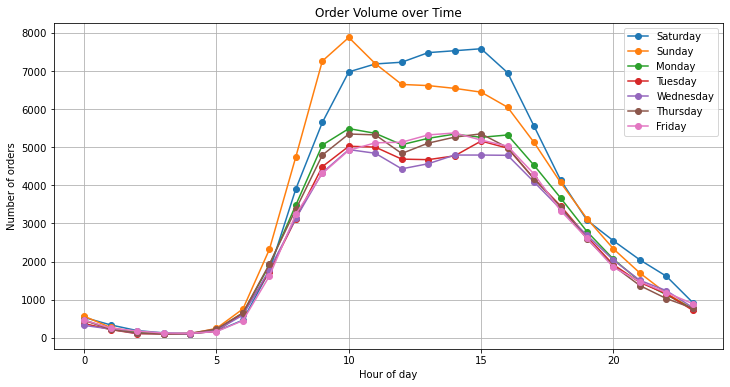

In [53]:
# I created a line plot early in the notebook to determine which days correspond to which order_dow values.
# This plot elegantly answers this question. I will update the legend names for clarity.

order_times_pivot = orders.pivot_table(index='order_hour_of_day', columns='order_dow', 
                                       values='order_id', aggfunc='count')

order_times_pivot.plot(figsize=[12,6], grid=True, style='o-',
          title='Order Volume over Time',
          ylabel='Number of orders',
          xlabel='Hour of day')
plt.legend(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
plt.show()


For all days, grocery orders peak between around 1000 and 1500, with most orders being placed between 0900 and 1700.

### [A3] What day of the week do people shop for groceries?

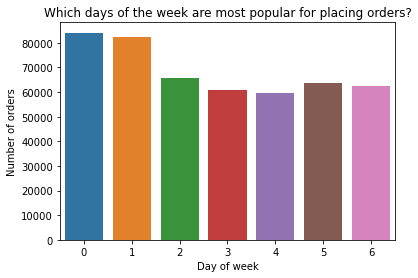

In [54]:
# Create bar graph of the number of orders placed per day
sns.countplot(data=orders, x='order_dow')
plt.title('Which days of the week are most popular for placing orders?')
plt.xlabel('Day of week')
plt.ylabel('Number of orders')
plt.show()

- My line plot above answered this question as well, but I wanted practice with bar plots. 
- Days 0 and 1 are distinctly the most popular days for placing grocery orders.

### [A4] How long do people wait until placing another order?

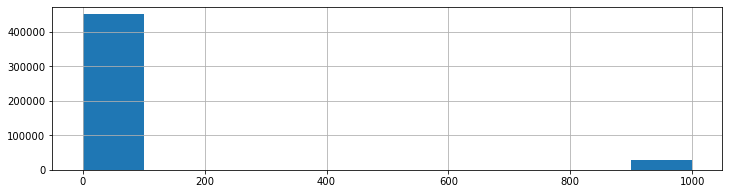

Total number of orders: 478952
Number of first orders: 28817
Percentage of orders that are first orders: 6.02 %
-----------------------------------------------------------------------------------------------------


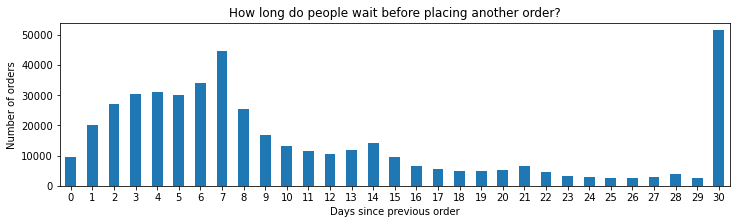

Number of orders that were placed after 30 days or more: 51337
Number of orders that were placed after 30 days or more: 10.72 %

Number of orders that were placed after between 2 and 7 days: 196971
Percentage of orders that were placed after between 2 and 7 days: 41.13 %


In [55]:
# I want to look at a histogram to determine how long people wait until placing another order.

orders.days_since_prior_order.hist(figsize=(12,3)) # Plot figure, including the 999 values desginating first-time orders
plt.show()

print("Total number of orders:", len(orders)) # How many orders were placed in total?

count_999 = orders[orders.days_since_prior_order == 999].order_id.count() # How many orders are first-time orders?
print("Number of first orders:", count_999)
# What percent of all orders are first-time orders?
print("Percentage of orders that are first orders:", round((count_999 / len(orders) * 100.0), 2), '%')
print('-----------------------------------------------------------------------------------------------------')

# Now let's update the data to omit these 999 values and plot a bar chart now that we only have 31 values.

days_since_ordering_real = orders[orders.days_since_prior_order != 999] # Store rows that are not first-time orders
days_since_ordering_real.days_since_prior_order.value_counts().sort_index().plot(kind='bar', figsize=(12,3), rot=0)
plt.xlabel('Days since previous order')
plt.ylabel('Number of orders')
plt.title('How long do people wait before placing another order?')
plt.show()

# I notice a large number of values at 30 days. The data is likely capped at 30 days. Let's see how many and what percent
# of the total these make up.

count_30 = orders[orders.days_since_prior_order == 30].order_id.count()
print("Number of orders that were placed after 30 days or more:", count_30)
print("Number of orders that were placed after 30 days or more:", round((count_30/len(orders) * 100.0), 2), '%')
print()

# I want to look at how many/what percent of orders are placed between 2 and 7 days, since that is where values are plateaued
# at the highest

count_2_to_7 = orders[(orders.days_since_prior_order <= 7) & (orders.days_since_prior_order >= 2)].order_id.count()
print("Number of orders that were placed after between 2 and 7 days:", count_2_to_7)
print("Percentage of orders that were placed after between 2 and 7 days:", round((count_2_to_7/len(orders) * 100.0), 2), '%')

Earlier, we replaced NaNs in this column with 999s, indicating that this was a customer's first order. These first orders make up 6% of the full dataset. Looking at a bar chart that excludes these values, peaks at around 7 days and 30 days are evident. The counts also do stay fairly high between 2 days and 7 days.

This data indicates that nearly half of all customers place orders after 7 or fewer days, or in other terms, at least once per week. About 41% of all customers reorder between 2 and 7 days after their previous order. There is also a relatively substantial subset (about 11%) of customers who wait at least 30 days before reordering.

# [B] Medium (must complete all to pass)

### [B1] Is there a difference in `'order_hour_of_day'` distributions on Wednesdays and Saturdays? Plot the histograms for both days and describe the differences that you see.

In [56]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478952 entries, 0 to 478951
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   order_id                478952 non-null  int32
 1   user_id                 478952 non-null  int32
 2   order_number            478952 non-null  int8 
 3   order_dow               478952 non-null  int8 
 4   order_hour_of_day       478952 non-null  int8 
 5   days_since_prior_order  478952 non-null  int16
dtypes: int16(1), int32(2), int8(3)
memory usage: 5.9 MB


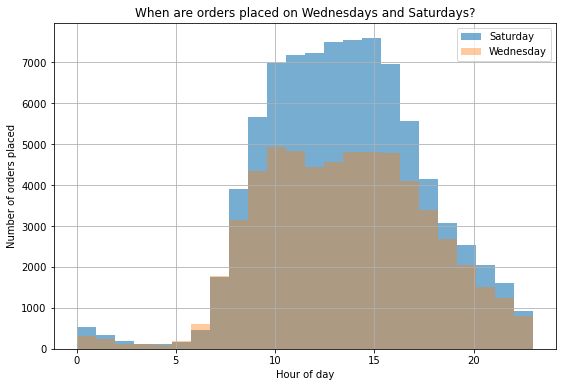

<Figure size 432x288 with 0 Axes>

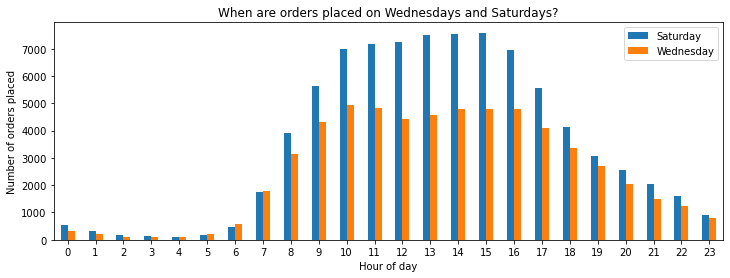

In [57]:
# I could use my line plot from above, but I will try out plotting multiple histograms on one figure.

wednesday_data = orders[orders.order_dow == 4] # Store rows for orders placed on Wednesdays
saturday_data = orders[orders.order_dow == 0] # Store rows for orders placed on Saturdays

# Plot semi-transparent histograms for direct comparison

saturday_data.order_hour_of_day.hist(alpha=0.6, bins=24, figsize=(9,6))
wednesday_data.order_hour_of_day.hist(alpha=0.4, bins=24)
plt.legend(['Saturday', 'Wednesday'])
plt.title('When are orders placed on Wednesdays and Saturdays?')
plt.ylabel('Number of orders placed')
plt.xlabel('Hour of day')
plt.show()
plt.clf()

# Let's also plot a bar chart

wed_sat_data = pd.concat([wednesday_data, saturday_data]) # Concatenate all Wed and Sat data
wed_sat_data_pivot = wed_sat_data.pivot_table(index='order_hour_of_day', aggfunc='count', 
                                              values='order_id', columns='order_dow') # Make pivot table
wed_sat_data_pivot.plot(kind='bar', figsize=(12,4), rot=0)
plt.legend(['Saturday', 'Wednesday'])
plt.title('When are orders placed on Wednesdays and Saturdays?')
plt.ylabel('Number of orders placed')
plt.xlabel('Hour of day')
plt.show()

Orders for both Wednesday and Saturday have very similar distributions with regards to times that orders are placed. Both days peak between about 1000 and 1700, though Saturdays counts are higher by about 2000-2500 per hour. At other hours of the day, the counts are very similar, though Saturday's are still slightly higher at nearly all hours of the day. For both days, the fewest orders are placed at 0400, though few orders are placed between midnight and 0600.

### [B2] What's the distribution for the number of orders per customer?

In [58]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478952 entries, 0 to 478951
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   order_id                478952 non-null  int32
 1   user_id                 478952 non-null  int32
 2   order_number            478952 non-null  int8 
 3   order_dow               478952 non-null  int8 
 4   order_hour_of_day       478952 non-null  int8 
 5   days_since_prior_order  478952 non-null  int16
dtypes: int16(1), int32(2), int8(3)
memory usage: 5.9 MB


count    157437.000000
mean          3.042182
std           2.746842
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          28.000000
Name: user_id, dtype: float64


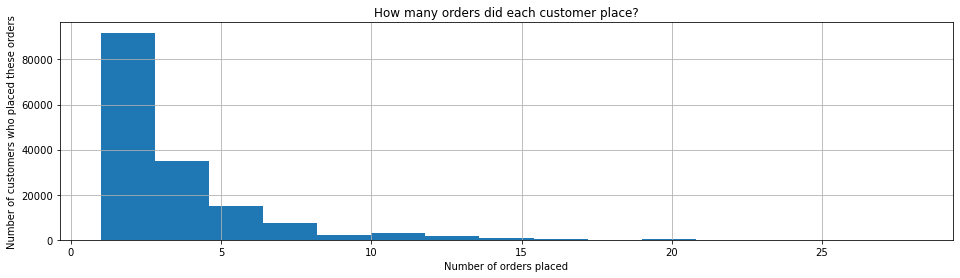

In [59]:
# I want to count up how many times each user_id appears in the data, which should equal the number of orders they placed.
order_counts = orders.user_id.value_counts() # Count up the instances
order_counts.hist(figsize=(16,4), bins=15) # Plot the histogram
plt.title('How many orders did each customer place?')
plt.xlabel('Number of orders placed')
plt.ylabel('Number of customers who placed these orders')

print(order_counts.describe())

In [60]:
# Something doesn't add up. I want to crosscheck the values above against order_numbers from the regular dataframe.
print(orders.order_number.describe())

# I want to look at one customer's data, sorted numerically by order_number, to see if the numbers flow smoothly or 
# if there are gaps.
orders[orders.user_id == 82516].sort_values(by='order_number') 

count    478952.000000
mean         17.157563
std          17.704457
min           1.000000
25%           5.000000
50%          11.000000
75%          23.000000
max         100.000000
Name: order_number, dtype: float64


,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
358340,2892855,82516,4,4,11,3
222069,2792498,82516,8,5,7,8
462166,2975419,82516,15,5,10,8
104062,1776734,82516,22,5,13,0
212165,2335664,82516,27,0,22,6
322413,1989841,82516,33,3,14,1
213355,1588805,82516,41,1,10,0
9407,2698450,82516,49,3,10,3
81285,2004651,82516,53,4,9,4
3,1768857,82516,56,0,20,10


I found it odd that the maximum order number is 100, which indicates that at least one customer has placed 100 orders. Yet, my value_counts series, counting instances of each user_id in the df, indicates that 28 orders is the most that any one customer has placed. I looked at one customer's information, and it is clear that a large number of their orders have been removed from the dataset. Likely during Practicum's dataset revisions?

- I will instead use the maximum order number for each customer. This method will almost certainly not be correct either because data may have been removed from order numbers above the current maximum values. 
- However, this method will be much more precise than the first method.

,order_number
count,157437.000000
mean,15.577571
std,17.215517
min,1.000000
25%,4.000000
50%,9.000000
75%,20.000000
max,100.000000


Text(0, 0.5, 'Number of customers who placed these orders')

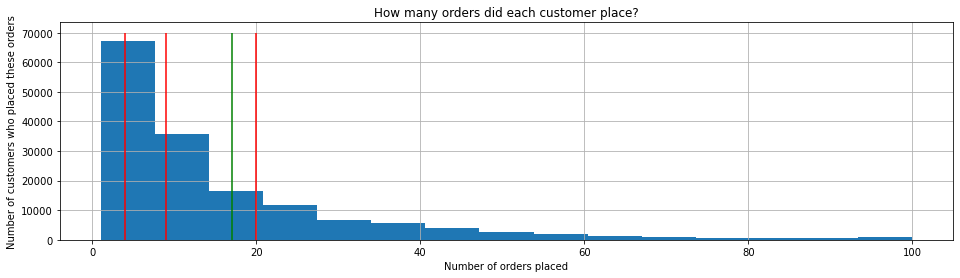

In [61]:
# I will make a pivot table that will take the maximum order number for each user_id, then plot it
orders_count_pivot = orders.pivot_table(index='user_id', values='order_number', aggfunc='max') # Make pivot table
display(orders_count_pivot.describe()) # Look at summary statistics of pivot table
orders_count_pivot.hist(figsize=(16,4), bins=15) # Plot histogram of data
plt.vlines(x=[4,9,20], ymin=0, ymax=70000, color='red') # Insert lines at 25,50,75 percentiles (using that .describe() info)
plt.vlines(x=17, ymin=0, ymax=70000, color='green') # Insert line at mean
plt.title('How many orders did each customer place?')
plt.xlabel('Number of orders placed')
plt.ylabel('Number of customers who placed these orders')

Looking at the histogram and summary statistics for the maximum order number per customer, we find a very right-skewed distribution centered at a median of 11 orders per customer. The presence of infrequent, but much higher order numbers, brings the mean to 17 orders per customer. The red lines on the histogram indicate the 25th percentile, the median, and the 75th percentile, further emphasizing the right-skew. The green line indicates the mean. We can say that most customers place beneath 20 orders in total, and the typical customer places around 11. The highest-ordering customers placed 100 orders.

### [B3] What are the top 20 popular products (display their id and name)?

In [62]:
# I need to make a pivot table to count instances of product_ids, filter it to only include the top 20 purchased items, 
# then join the product df info onto this table, and filter the contents of the table to exclude unneeded information.

product_counts_pivot = order_products.pivot_table(index='product_id',
                                                  aggfunc='count') # Make pivot table

product_counts_pivot = product_counts_pivot.sort_values(by='order_id', ascending=False).head(20) # Sort and filter
# display(product_counts_pivot) # Verify it worked
product_counts_info = product_counts_pivot.join(products.set_index('product_id')).reset_index() # Join product df
# display(product_counts_info)
top_20_products = product_counts_info[['product_id', 'product_name', 'order_id']] # Filter for certain columns
top_20_products.columns = ['Product ID', 'Product name', 'Number of orders'] # Rename columns for readability
display(top_20_products)

,Product ID,Product name,Number of orders
0,24852,banana,66050
1,13176,bag of organic bananas,53297
2,21137,organic strawberries,37039
3,21903,organic baby spinach,33971
4,47209,organic hass avocado,29773
5,47766,organic avocado,24689
6,47626,large lemon,21495
7,16797,strawberries,20018
8,26209,limes,19690
9,27845,organic whole milk,19600


The top 20 products are all produce or dairy. 15 of them are organic. This may be a surprising result, because organic produce seems counterintuitive to me as a best seller. It would be interesting to view geographic data for each row in the order_products df, because these purchases may be concentrated mainly in certain areas, such as big cities, or on the west coast.

# [C] Hard (must complete at least two to pass)

### [C1] How many items do people typically buy in one order? What does the distribution look like?

In [63]:
order_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4545007 entries, 0 to 4545006
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int32
 1   product_id         int32
 2   add_to_cart_order  int16
 3   reordered          int8 
dtypes: int16(1), int32(2), int8(1)
memory usage: 47.7 MB


,product_id
count,450046.000000
mean,10.098983
std,7.540206
min,1.000000
25%,5.000000
50%,8.000000
75%,14.000000
max,127.000000


,product_id
order_id,
61355,127
3308010,115
2136777,108
171934,104
1959075,98
102236,95
1730767,95
1800005,92
2926893,92


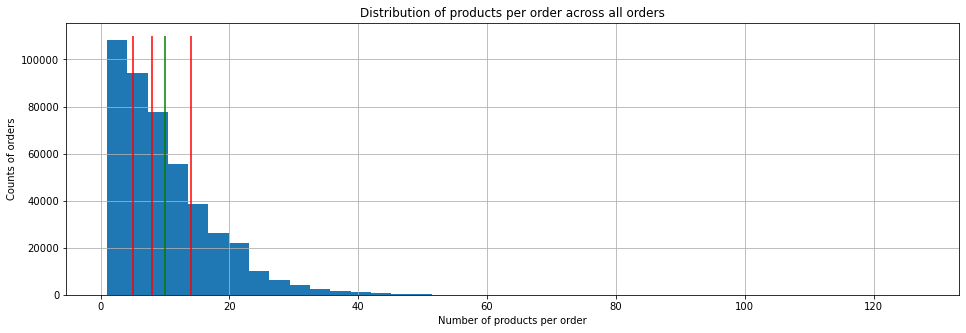

In [64]:
# I want to make a pivot table counting the number of products in each order, then plot a histogram of that

products_per_order = order_products.pivot_table(index='order_id', aggfunc='count', values='product_id') # Make pivot table
display(products_per_order.describe())
products_per_order.hist(bins=40, figsize=(16,5)) # Plot histogram
plt.title('Distribution of products per order across all orders')
plt.xlabel('Number of products per order')
plt.ylabel('Counts of orders')
plt.vlines(x=[5,8,14], ymin=0, ymax=110000, color='red') # Insert lines at 25,50,75 percentiles, using values from .describe()
plt.vlines(x=10, ymin=0, ymax=110000, color='green') # Insert line at mean

# Since the histogram is so right-skewed, I want to check out how many outliers there truly are.
display(products_per_order.sort_values(by='product_id', ascending=False).head(25))

The distribution of the number of products per order is very right-skewed, although these high outliers are low in number and do not skew the mean too much. The median number of products per order is 8, and the mean number is about 10. The maximum number of products per order is 127. Smaller orders are most common, with the number of orders being highest when the number of products per order is at a minimum, and the number of orders steadily decreasing while the number of products per order increases.

The 25th highest count is 75, so many of the bins on the right half of the histogram have very few, if any, values. I tried out using a histogram that omits values above 50, but the distribution pattern did not change, so I kept the histogram with the full range of values.

### [C2] What are the top 20 items that are reordered most frequently (display their names and product IDs)?

In [65]:
# I want to filter out rows where the products were reordered, thn make a pivot table counting instances of these products, 
# sort and filter to get the top 20 products, then join the product data onto this df and reformat the result for readability.

reordered_data = order_products.query('reordered == 1') # Store rows where the item was reordered
reordered_pivot = reordered_data.pivot_table(index='product_id', aggfunc='count') # Make pivot table
reordered_pivot_20 = reordered_pivot.sort_values(by='order_id', ascending=False).head(20) # Sort and filter
reordered_info = reordered_pivot_20.join(products.set_index('product_id')).reset_index() # Join products df
top_20_reordered = reordered_info[['product_id', 'product_name', 'order_id']] # Remove unneeded columns
top_20_reordered.columns = ['Product ID', 'Product name', 'Number of orders'] # Reformar column names
display(top_20_reordered)

,Product ID,Product name,Number of orders
0,24852,banana,55763
1,13176,bag of organic bananas,44450
2,21137,organic strawberries,28639
3,21903,organic baby spinach,26233
4,47209,organic hass avocado,23629
5,47766,organic avocado,18743
6,27845,organic whole milk,16251
7,47626,large lemon,15044
8,27966,organic raspberries,14748
9,16797,strawberries,13945


In [66]:
# The list appears very similar to the top 20 products from above. Let's check how many are similar.
display(top_20_reordered['Product name'].isin(top_20_products['Product name'])) # Which products show up anywhere in the other df?
top_20_reordered.isin(top_20_products) # Which products show up in the same location as in the other df?

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19    False
Name: Product name, dtype: bool

,Product ID,Product name,Number of orders
0,True,True,False
1,True,True,False
2,True,True,False
3,True,True,False
4,True,True,False
5,True,True,False
6,False,False,False
7,False,False,False
8,False,False,False
9,False,False,False


19 of the 20 top reordered products are also a top 20 product, regardless of reorder status. Only the 20th on each dataframe is different. The orders in which the products appear varies between the datasets, but the top 6 products are identical for both datasets. The regular banana is both the top seller and the top reordered product!

### [C3] For each product, what proportion of its orders are reorders?

In [67]:
# We will need to find the total number of orders for each product, and then the total number of reorders for each product,
# then calculate the proportion for each product.

product_counts_pivot = order_products.pivot_table(index='product_id', aggfunc='count', values='order_id') # Reuse previous pivot
reordered_pivot = reordered_data.pivot_table(index='product_id', aggfunc='count', values='reordered') # Reuse previous pivot
proportions_table = product_counts_pivot.join(reordered_pivot) # Join these into one df
proportions_table['proportion (%)'] = round(((proportions_table.reordered / proportions_table.order_id) * 100.0), 2) # Create new column

proportions_table = proportions_table.join(products.set_index('product_id')) # Join products to get product names
# display(proportions_table)

print(products.query('product_id==5')) # Product #5 is missing. It is a product, right?
print(order_products.query('product_id==5')) # Looks like it was never ordered. That's okay.

# I ran into a number of NaN product information. This is because I removed 104 duplicates. However, that earlier decision led 
# to incomplete information here. I went back and commented out the code block that removed those duplicates. 
# Now I can include product names with my results.

proportions_table = proportions_table[['product_name', 'proportion (%)']] # Filter out columns
proportions_table.columns = ['Product name', 'Proportion reordered (%)'] # Rename columns
display(proportions_table)

   product_id               product_name  aisle_id  department_id
4           5  green chile anytime sauce         5             13
Empty DataFrame
Columns: [order_id, product_id, add_to_cart_order, reordered]
Index: []


,Product name,Proportion reordered (%)
product_id,,
1,chocolate sandwich cookies,56.43
2,all-seasons salt,NaN
3,robust golden unsweetened oolong tea,73.81
4,smart ones classic favorites mini rigatoni wit...,51.02
7,pure coconut water with orange,50.00
...,...,...
49690,high performance energy drink,80.00
49691,original pancake & waffle mix,43.06
49692,organic instant oatmeal light maple brown sugar,41.67


We now have a dataframe that shows us the proportion of orders that were reorders for each product, with NaNs showing instances where there were no reorders, along with key product identifying information in the form of product ID, and enhanced readability with the addition of product names. This data could be helpful in answering future questions.

### [C4] For each customer, what proportion of their products ordered are reorders?

In [68]:
# I will look at how many products each customer ordered, look at how many of them were reorders, then calculate the proportion.
# First I will need to merge orders df and order_products_df

user_products_df = orders.merge(order_products, on='order_id') # An inner merge should be good
display(user_products_df.head())
user_products_pivot = user_products_df.pivot_table(index='user_id', aggfunc='count', values='product_id') # Count up products
user_products_pivot.columns=['Number of products'] # Rename columns
# display(user_products_pivot)
user_products_df_reordered = user_products_df.query('reordered==1') # Get rows where the product was reordered
# Make pivot table
user_products_reordered_pivot = user_products_df_reordered.pivot_table(index='user_id', aggfunc='count', values='product_id')
user_products_props = user_products_pivot.join(user_products_reordered_pivot) # Join pivot tables

# Calculate proportions and add column to the df
user_products_props['Proportion reordered (%)'] = \
            round(((user_products_props.product_id / user_products_props['Number of products']) * 100.0), 2)
user_products_props = user_products_props[['Proportion reordered (%)']] # Filter out columns
display(user_products_props)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,1515936,183418,11,6,13,30,19048,1,1
1,1515936,183418,11,6,13,30,47766,3,1
2,1515936,183418,11,6,13,30,45066,9,0
3,1515936,183418,11,6,13,30,24082,11,0
4,1515936,183418,11,6,13,30,24363,4,0


,Proportion reordered (%)
user_id,
2,3.85
4,NaN
5,66.67
6,NaN
7,92.86
...,...
206203,22.22
206206,71.43
206207,89.13


We now have a dataframe showing how many products each customer purchased, the number of these products that were reordered, and the proportion of products they ordered that were reorders. NaNs appear when a product was not reordered. This data could be used to determine which customers are more consistent with their orders, vs inconsistent. 

### [C5] What are the top 20 items that people put in their carts first? 

In [69]:
# Let's use the merged dataframe from the previous problem for this question. We can filter the rows where add_to_cart_order 
# is 1, then make a pivot table counting the number of times these products were purchased, and sort/filter to get the top 20.

first_product_df = user_products_df.query('add_to_cart_order==1') # Store rows where product was first in order
first_product_pivot = first_product_df.pivot_table(index='product_id', aggfunc='count', values='user_id') # Make pivot table
first_product_top_20 = first_product_pivot.sort_values(by='user_id', ascending=False).head(20) # Sort and filter
first_product_top_20 = first_product_top_20.join(products.set_index('product_id')).reset_index() # Join products df
first_product_top_20 = first_product_top_20[['product_id', 'product_name', 'user_id']] # Select certain columns
first_product_top_20.columns = ['Product ID', 'Product name', 'Number of orders'] # Rename columns
display(first_product_top_20)

,Product ID,Product name,Number of orders
0,24852,banana,15562
1,13176,bag of organic bananas,11026
2,27845,organic whole milk,4363
3,21137,organic strawberries,3946
4,47209,organic hass avocado,3390
5,21903,organic baby spinach,3336
6,47766,organic avocado,3044
7,19660,spring water,2336
8,16797,strawberries,2308
9,27966,organic raspberries,2024


Here we have a dataframe that shows the top 20 products that people added to their carts first. Bananas are again in the top spot, showing that they are both the most popular and most often the first product that people add to their carts. Without specifically comparing the dataframes, I notice that spring water and soda were not present in the top 20 most popular products or top 20 reordered products lists. Regardless, we have another dataframe that could be useful in answering further questions about the data.

# Conclusion

I loaded five files into dataframes and explored the data that they contained by simply using methods such as .head(), .describe(), and .info(). Through this I was able to look at rows of the data itself, as well as summary statistics, datatypes, and non-null column counts. I could see at a glance that most of the values had logical ranges, such as days of week and hours of the day, along with which columns contained null values. Since the dataframes were somewhat large, I changed the integer types to smaller integer types where possible to save on memory. I also plotted order numbers across days of the week and hours of the day to determine which day corresponded with Day 0; because Day 0 and Day 1 were the busiest, I decided that the data for Day 0 and Day 1 most reasonably correlated with what I expected the data for Saturday and Sunday to look like.

Next I checked every dataframe for duplicates. I needed my data to be free from any duplicated data that could throw off my calculations later in the project. I first checked for fully duplicate rows, and found none in any of the dataframes. I checked for duplicate departments and aisles by hand, that may have resulted from a misspelling, and found none. I checked the three dataframes related to orders and products for problems related to duplicate names, duplicate order numbers, duplicate add_to_order numbers, etc and ultimately found nothing that I needed to remove.

I next looked for missing values. In my products df, a number of product names were missing, each of which I replaced with "Unknown". In my orders df, the days_since_prior_order column contained a number of missing values, but I correlated these with instances where it was a first order (where a previous order did not exist), and I replaced these missing values with 999's. In my order_products df, I found missing values in the add_to_cart_order column, and these existed because the number of products per order was capped at 64, and therefore any add_to_cart_order over 64 registered as NaN; I also replaced these with 999's.

I discovered that people typically place orders on Instacart between 0900 and 1600 on Day 0 and Day 1, which I decided were Saruday and Sunday, but which may in fact be Monday and Tuesday. Online infrastructure and sufficient manpower is especially critical during peak hours on Day 0 and Day 1 between 1000 and 1500, when orders are peaking. Most people wait about a week or less before placing another order, though a number of people do wait 30 days or longer. 

Yet, most people have placed 20 orders or fewer. Since this data was taken throughout a year (with 52 weeks), it would be interesting to see in which months they typically order more frequently. Perhaps most orders happen during summer, when people may be busier? Or perhaps most orders happen in winter, when people may be more likely to order delivery? More temporal information, along with delivery/pickup data, would be helpful in filling in this missing information, and clearing up this apparent discrepancy.

The median size of most people's orders is about 8 products. The median number of orders placed by customers in 2017 is 9. These numbers suggest that the "typical" customer does not exlusively use Instacart for their grocery shopping. This market of people who already use Instacart, but who could use Instacart more heavily, may be a good market to target with marketing and promotions. Further analysis could reveal specific user_id's that would likely be part of this market.

The top 20 most ordered products, surprisingly, consisted mostly of regular/organic produce and dairy. The top 20 most reordered products list was very similar, as was the list of the top 20 products that people added to their carts first. In all cases, regular bananas were most popular, followed by organic bananas. Promotions for these products, and other popular products that tend to be reordered, could help attract customers to buying these products for the first time, and then continuing to buy them even after the promotions have ended.

I also created some new dataframes that contain the proportions of product orders that are reorders for each product, and the proportions of product orders that are reorders per customer. These new columns could be helpful in any further analysis concerning product popularity.

Overall, this project has been a success in that I effectively used a variety of appropriate techniques to explore, process, and analyze the data, and made inferences based on my results.